In [ ]:
# Required Library
import os
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
import keras.backend as K
from sklearn.metrics import roc_curve,confusion_matrix,f1_score, roc_auc_score
from keras.layers import Concatenate, Dot, Input, LSTM,SimpleRNN,GRU
from keras.layers import RepeatVector, Dense, Activation, BatchNormalization
from keras.layers import Reshape, Dropout, Add, Subtract, Flatten, Embedding
from keras.models import load_model, Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# Load function from rnn_utils.py file
os.chdir('/content/drive/My Drive/My DataScience Project/Notebook')
from rnn_utils import *

#Connect to GDrive & Dataset Path
os.chdir('/content/drive/My Drive/My DataScience Project/Dataset')
data = pd.read_csv('Customer_Data.csv')

In [ ]:
# Hyperparameters
n_s =192 # 385  # Hidden state of LSTM 
n_a =96 # 288 # Hidden units of LSTM
n_s_1 =192 #25 # 192 # 385 # Units in 1st Hidden layer of ANN
n_s_2 =96 # 19 # 96 # 288 # Units in 2nd Hidden layer of ANN

In [ ]:
# Preprocessing Customer Path to on hot encoding for LSTM input & numerical variables for ANN
def preprocess_data(data):
  cat(data,'screen_list','screen_len',',')
  text = data.screen_list
  seq_length = max(data.screen_len)+1
  token = Tokenizer()
  token.fit_on_texts(text)
  vocab_size = len(token.word_index)+1
  encode = token.texts_to_sequences(text)
  pad_sequence = tf.keras.preprocessing.sequence.pad_sequences
  one_hot_encode =pad_sequence(encode,maxlen=seq_length,padding='post',truncating='post')
  idx = [x for x in range(data.shape[0])]
  np.random.seed(111)
  random.shuffle(idx)
  tr_idx = idx[0:int(0.9*len(idx))]
  te_idx = idx[int(0.9*len(idx)):]
  X_train = one_hot_encode[tr_idx]
  X_test = one_hot_encode[te_idx]
  all_X = np.array(list(map(lambda x: to_categorical(x, num_classes=vocab_size),one_hot_encode)), ndmin=3)
  X_tr = np.array(list(map(lambda x: to_categorical(x, num_classes=vocab_size), X_train)), ndmin=3)
  X_te = np.array(list(map(lambda x: to_categorical(x, num_classes=vocab_size), X_test)), ndmin=3)
  ds = data.drop(columns=['enrolled_date','screen_len','screen_list','user'])
  ds.hour = ds.hour.str[:3]
  ds.hour = ds.hour.astype(int)
  ds.first_open = pd.to_datetime(ds.first_open,format='%Y-%m-%d %H:%M:%S.%f')
  ds['day']=ds.first_open.dt.day
  ds['month']=ds.first_open.dt.month
  X = ds.drop(columns=['enrolled','first_open'])
  y = ds.enrolled
  X_cust_tr = X.iloc[tr_idx,:]
  X_cust_te = X.iloc[te_idx,:]
  y_tr = y.iloc[tr_idx]
  y_te = y.iloc[te_idx]
  Numeric_var_count = X_cust_tr.shape[1]
  s0_init_tr = np.zeros((len(tr_idx),n_s))
  s0_init_te = np.zeros((len(te_idx),n_s))
  paths = text[tr_idx].reset_index().screen_list
  return dict({'Cust_Path_Train':X_tr,'Cust_Path_Test':X_te,'Cust_Demo_Train':X_cust_tr,'Cust_Demo_Test':X_cust_te,
               'Enrolled_Train':y_tr,'Enrolled_Test':y_te,'Seq_Len':seq_length,'Vocab_Size':vocab_size,
               'Other_Var_Count':Numeric_var_count,'s0_tr':s0_init_tr,'s0_te':s0_init_te,'paths':paths,
               'all_y':y,'all_X':all_X,'One_hot':one_hot_encode,'Word_index':token.word_index})
  
# One-Step-Attention for LSTM
def one_step_attention(a, s_prev):
  repeator = RepeatVector(myDict['Seq_Len'])
  concatenator = Concatenate(axis=-1)
  densor1 = Dense(10, activation = "tanh")
  densor2 = Dense(1, activation = "relu")
  activator = Activation(softmax, name='attention_weights') # We are using a custom softmax loaded in this notebook
  dotor = Dot(axes = 1)
  s_prev = repeator(s_prev)
  concat = concatenator([a,s_prev])
  e = densor1(concat)
  energies = densor2(e)
  alphas = activator(energies)
  context = dotor([alphas,a])
  return context

def build_model():
  input_att = Input(shape=(myDict['Seq_Len'],myDict['Vocab_Size']),name='LSTM_input_path')
  s0 = Input(shape=(n_s,), name='s0_hidden_state_input')
  a = LSTM(n_a,return_sequences=True)(input_att) # LSTM Unit
  context = one_step_attention(a,s0) # attention unit
  c = Flatten()(context)
  out_att = Dense(32, activation = 'relu', name='output_path')(c)
  numeric_var = Input(shape=(myDict['Other_Var_Count'],),name='input_continous_var')
  out_numeric_var = Dense(n_s_1,activation='relu')(numeric_var)
  out_numeric_var = Dropout(0.2)(out_numeric_var)
  out_numeric_var = BatchNormalization()(out_numeric_var)
  out_numeric_var = Dense(n_s_2,activation='relu')(out_numeric_var)
  out_numeric_var = Dropout(0.2)(out_numeric_var)
  out_numeric_var = BatchNormalization()(out_numeric_var)
  out_numeric_var = Dense(32,activation='relu',name='output_continous_var')(out_numeric_var)
  added = Add()([out_att, out_numeric_var])
  out_all = Dense(1,activation='sigmoid')(added)
  model = Model([input_att,s0,numeric_var],out_all)
  return model

# Train Model
def train_model(save_name,p_epochs=10,p_batch_size=128,loss='binary_crossentropy',opt='adam',metrics=['accuracy']):
  model.compile(loss=loss,optimizer=opt,metrics=metrics)
  history = model.fit([myDict['Cust_Path_Train'],myDict['s0_tr'],myDict['Cust_Demo_Train']], myDict['Enrolled_Train'], epochs=p_epochs, batch_size=p_batch_size,verbose=1)
  plot_loss(history,p_epochs)
  plot_acc(history,p_epochs)
  save_weight(save_name,model)
  print(model.summary())

# Determine critical path
def critical_paths():
  prob = model.predict([myDict['Cust_Path_Train'],myDict['s0_tr'],myDict['Cust_Demo_Train']])
  cp_idx = sorted(range(len(prob)), key=lambda k: prob[k], reverse=True)
  cp_p = [myDict['paths'][p] for p in cp_idx[0:100]]
  cp_p_2 = set(map(tuple, cp_p))
  return list(map(list,cp_p_2))

# Weightage of screen which have more weights and count of total visit cummulative to all users
def attributes():
  layer = model.layers[11] # Attention Activator Layer
  all_X = myDict['all_X']
  y=myDict['all_y']
  newlines = myDict['One_hot']
  m_all,_,_ = all_X.shape
  s_all = np.zeros((m_all, n_s))
  f_f = K.function([model.input[0],model.input[1]], [layer.output])
  r=f_f([all_X[y==1],s_all[y==1]])[0].reshape(all_X[y==1].shape[0],all_X[y==1].shape[1])
  att_f = {m:0 for m in range(1,myDict['Vocab_Size'])}
  att_count_f = {m:0 for m in range(1,myDict['Vocab_Size'])}
  chan_used = newlines[y==1]
  for m in range(chan_used.shape[0]):
    for n in range(chan_used.shape[1]):
      if chan_used[m,n]!=0:
        att_f[chan_used[m,n]] += round(r[m,n],3)
        att_count_f[chan_used[m,n]] += 1
  return att_f,att_count_f

# Get Weight for each screen and no of counts. Return Summary
def get_summary():
  weights,count = attributes()
  df_WordIndex = pd.DataFrame(list(myDict['Word_index'].items()),columns = ['ScreenName','ScreenIndex'])
  df_weights = pd.DataFrame(list(weights.items()),columns = ['Index','Weights'])
  df_Count = pd.DataFrame(list(count.items()),columns = ['Index','Count'])
  df_Summary = df_WordIndex.copy()
  df_Summary['Weights']=df_weights['Weights']
  df_Summary['Count']=df_Count['Count']
  return df_Summary

In [ ]:
# Preprocess raw data
myDict = preprocess_data(data)

In [ ]:
# Build
model = build_model()

In [ ]:
# Train, save and validate loss & accuracy
#train_model('model_weights_LSTM',p_epochs=100) # model_weights - LSTM, 192,96,192,96 # model_weights_LSTM_DrBN_Half (192,96,192,96)

In [ ]:
# Load Weights
load_weight('model_weights_LSTM',model) # model_weights_LSTM_2 # model_weights_LSTM_DrBN

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LSTM_input_path (InputLayer)    (None, 80, 138)      0                                            
__________________________________________________________________________________________________
s0_hidden_state_input (InputLay (None, 192)          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 80, 96)       90240       LSTM_input_path[0][0]            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 80, 192)      0           s0_hidden_state_input[0][0]      
____________________________________________________________________________________________



 1. Test dataset performance:

[[1711  176]
 [ 270 2843]]
Accuracy: 0.911, AUC: 0.972
None


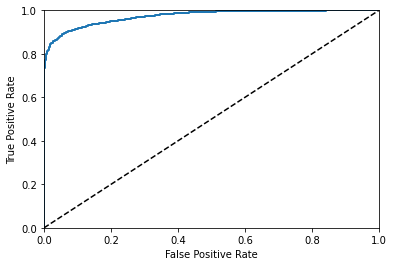

In [ ]:
# Accuracy and AUC of Test Data
print('\n\n 1. Test dataset performance:\n')
auc_score_test(0.5,model,myDict)



 2. Train performance:

[[15378  1661]
 [ 2276 25685]]
Accuracy: 0.913, AUC: 0.974
None


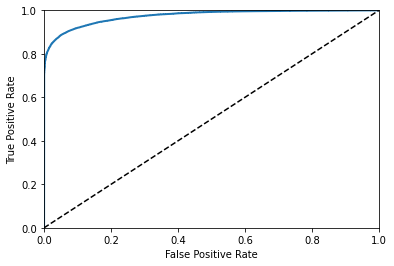

In [ ]:
# Accuracy and AUC of Training Data
print('\n\n 2. Train performance:\n')
auc_score_train(0.5,model,myDict)

In [ ]:
# Get top 100 unique path with high prediction probability
lt = critical_paths()

In [ ]:
# top 5 path
lt[:5]

[['product_review',
  'product_review2',
  'ScanPreview',
  'VerifyDateOfBirth',
  'VerifyCountry',
  'VerifyPhone',
  'VerifyToken',
  'VerifySSN',
  'MLWebView',
  'product_review',
  'SelectInstitution',
  'BankVerification',
  'product_review',
  'product_review',
  'product_review',
  'Loan4'],
 ['Cycle',
  'Splash',
  'Home',
  'product_review',
  'product_review',
  'product_review3',
  'location',
  'VerifyCountry',
  'product_review',
  'product_review',
  'Leaderboard',
  'Loan2',
  'Credit3Container',
  'Institutions',
  'VerifyDateOfBirth',
  'VerifyPhone',
  'VerifySSN',
  'Credit1',
  'Credit3Dashboard'],
 ['idscreen',
  'product_review',
  'Home',
  'product_review',
  'product_review',
  'product_review3',
  'VerifyDateOfBirth',
  'location',
  'VerifyCountry',
  'VerifyPhone',
  'VerifyToken',
  'ResendToken',
  'product_review',
  'product_review2',
  'product_review3',
  'product_review',
  'VerifySSN',
  'WebView'],
 ['idscreen',
  'joinscreen',
  'Cycle',
  'Credit

In [ ]:
# Get Screen Details which has more weightage and most visit count when conversion is True
df_Summary = get_summary()

In [ ]:
# Top 5 screen
df_Summary[:][{'ScreenName','Weights','Count'}].head()

,ScreenName,Weights,Count
0,product_review,1623.662004,69657
1,home,316.614001,23711
2,scanpreview,17.911000,22119
3,verifyphone,68.123000,20967
4,location,135.608000,18970


In [ ]:
# Most import screen which is more likely for conversion
df_Summary['Screen_Avg_Weights'] = df_Summary.Weights*100/df_Summary.Count

In [ ]:
df_Summary[:][{'ScreenName','Screen_Avg_Weights'}].sort_values(by='Screen_Avg_Weights',ascending=False).head()

,ScreenName,Screen_Avg_Weights
81,loan,38.363367
131,identityverification,13.900000
136,idandselfiecamerascreen,13.500001
121,employmentsummary,12.905263
101,loanappschedulecall,12.712903
